## Independent Multiple Time Series Forecasting: 
Forecast multiple time series with a single model, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values.

This will be used for several reasons:
- Baseline model
- what can we expect?
- is it useful to use more sophisticated models? (Seq2Seq Deep Learning models) are they better?

Multi-series forecasts do not always outperform single-series forecasts. Which one works best depends largely on the characteristics of the use case to which they are applied. However, the following heuristic is worth keeping in mind:

#### Advantages of multi-series
- It is easier to maintain and monitor a single model than several.
- Since all time series are combined during training, the model has a higher learning capacity even if the series are short.
- By combining multiple time series, the model can learn more generalizable patterns.

#### Disadvantages of multi-series
- If the series do not follow the same internal dynamics, the model may learn a pattern that does not represent any of them.
- The series may mask each other, so the model may not predict all of them with the same performance.
- It is more computationally demanding (time and resources) to train and backtest a big model than several small ones.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# one of the best models for time series forecasting, as research and production deployments examples demonstrate
from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [4]:
np.random.seed(2024)

#### Why LightGBM?
Tree-based algorithm, fast, efficient, scalable. One of the best models for time series forecasting. As the other GB algorithms, it builds a series of decision trees iteratively. Each tree tries to correct the mistakes made by the previous ones. Trees are built minimizing the loss function by adding weak learners in a sequential manner, where each subsequent tree learns from the residuals of the ensemble of trees built so far.

Unlike traditional depth-wise tree growth, LightGBM uses a leaf-wise growth strategy. Instead of growing the tree level by level (breadth-wise), LightGBM chooses the leaf with the maximum delta loss to grow. This results in a more balanced tree and reduces the number of levels in the tree, which contributes to faster training times.

LigthGBM also uses 2 other techniques that make this algorithm really effective: GOSS and EFB.
- Gradient-based One-Side Sampling (GOSS) to reduce the number of data instances used for training each tree. GOSS keeps the instances with large gradients (which contribute more to the learning process) and randomly samples the instances with small gradients. This allows for faster training without sacrificing much in terms of model performance.
- Exclusive Feature Bundling (EFB) to further improve efficiency. EFB groups exclusive features together during training, allowing for reduced memory usage and faster computation.

#### What we will do...
We will employ a simple, straight-forward, random, not-tuned, with no exogenous variables nor feature engineered LightGBM first on individual stocks and then a global model on the whole dataset (independent forecasting) and we will compare them. We will then perform preselection according to the predictions (with and without backtesting) and check the performance of the portfolios.

#### Load data

In [5]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
excess_returns = pd.read_pickle('data/exc_returns.pkl')
index_returns = pd.read_pickle('data/index_returns.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

In [6]:
data = tukey.reset_index().rename(columns={'index':'Date'}).set_index('Date')
data.head(8)

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,153.939608,15.863052,70.854575,44.436658,19.238627,1.380126,72.813778,127.405070,3.231326,13.850115,...,105.634999,7.310501,49.852665,61.648194,7.369072,18.959361,12.610719,29.582595,67.114440,8.771007
2013-01-08,152.295129,15.864724,70.827743,44.922120,19.152028,1.390526,73.053974,126.747672,3.202159,13.846611,...,104.938642,7.356010,49.264694,61.258046,7.436251,18.885706,12.580650,30.070623,66.745362,8.812163
2013-01-09,150.639015,15.827395,71.009542,45.323106,19.125098,1.405432,73.282788,126.031903,3.195986,13.749587,...,104.897190,7.447657,48.849551,61.011026,7.526238,18.937751,12.583433,30.564229,66.302363,8.861539
2013-01-10,149.452580,15.727265,70.822367,45.607353,19.161744,1.428110,73.181097,124.892381,3.190310,13.623088,...,104.390636,7.557309,48.616030,60.806893,7.616594,18.997714,12.550908,31.038729,65.602069,8.973196
2013-01-11,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-14,149.933382,15.487656,71.344228,45.629157,19.635128,1.473812,73.101598,123.811027,3.212000,13.681092,...,104.542030,7.710230,48.700000,61.015621,7.751773,19.216099,12.548296,31.527151,65.151129,9.082648
2013-01-15,151.252415,15.418798,71.295815,45.688668,19.628250,1.485061,72.674043,123.981557,3.232909,13.658883,...,104.692494,7.706911,48.428008,60.776038,7.762634,19.263300,12.466558,31.531555,65.562005,9.037267
2013-01-16,151.454902,15.342877,71.552748,44.982329,19.627959,1.481329,72.442307,124.871308,3.231103,13.625171,...,105.361890,7.731382,48.145124,60.026067,7.744269,19.316224,12.347364,31.409631,66.192436,8.996555


In [7]:
data.shape

(1269, 41)

In [8]:
# adding saturdays and sundays and filling those NAs with a forward fill (fill them with the price of fridays)
data = data.asfreq('D').ffill()
data.head(8)

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,153.939608,15.863052,70.854575,44.436658,19.238627,1.380126,72.813778,127.405070,3.231326,13.850115,...,105.634999,7.310501,49.852665,61.648194,7.369072,18.959361,12.610719,29.582595,67.114440,8.771007
2013-01-08,152.295129,15.864724,70.827743,44.922120,19.152028,1.390526,73.053974,126.747672,3.202159,13.846611,...,104.938642,7.356010,49.264694,61.258046,7.436251,18.885706,12.580650,30.070623,66.745362,8.812163
2013-01-09,150.639015,15.827395,71.009542,45.323106,19.125098,1.405432,73.282788,126.031903,3.195986,13.749587,...,104.897190,7.447657,48.849551,61.011026,7.526238,18.937751,12.583433,30.564229,66.302363,8.861539
2013-01-10,149.452580,15.727265,70.822367,45.607353,19.161744,1.428110,73.181097,124.892381,3.190310,13.623088,...,104.390636,7.557309,48.616030,60.806893,7.616594,18.997714,12.550908,31.038729,65.602069,8.973196
2013-01-11,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-12,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-13,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-14,149.933382,15.487656,71.344228,45.629157,19.635128,1.473812,73.101598,123.811027,3.212000,13.681092,...,104.542030,7.710230,48.700000,61.015621,7.751773,19.216099,12.548296,31.527151,65.151129,9.082648


In [9]:
data.shape

(1818, 41)

#### Train - Test split

In [10]:
end_train = '2016-12-30'

In [11]:
data_train, data_test = data.loc[:end_train, :], data.loc[end_train:, :]

In [12]:
data_train.shape, data_test.shape

((1454, 41), (365, 41))

#### Individual forecaster for each Stock

In [13]:
# Train and backtest a model for each stock: ForecasterAutoreg
items = []
mae_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):

    # Define forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=1),
                     lags          = 14,
                     transformer_y = MinMaxScaler()
                 )

    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        initial_train_size = len(data_train),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )

    items.append(item)
    mae_values.append(metric)
    predictions[item] = preds

# Results
uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

100%|██████████| 41/41 [00:11<00:00,  3.51it/s]


#### Multiseries forecaster

In [14]:
# Train and backtest a model for all stocks: ForecasterAutoregMultiSeries
items = list(data.columns)

forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=1),
                    lags               = 14,
                    transformer_series = MinMaxScaler(),
                )

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = data,
                                       levels             = items,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data_train),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True )

# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))

  0%|          | 0/52 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,VOW3 GY Equity,1.565735
1,ENGI FP Equity,0.130368
2,BAYN GY Equity,0.933749


,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2016-12-31,116.032863,12.116124,97.367808,60.500420,27.105457,2.434596,75.810542,179.279373,4.160396,23.930718,...,172.356944,6.419196,105.739503,82.356468,13.428452,15.415872,6.676466,15.474475,100.180227,16.258329
2017-01-01,116.084299,12.116124,97.367808,60.269698,26.977296,2.434596,75.804319,178.164573,4.166176,23.882045,...,172.356944,6.419196,104.794913,81.841044,13.388155,15.442769,6.676466,15.420751,100.206126,16.254139
2017-01-02,116.084299,12.116124,97.367808,60.079909,26.904281,2.434596,75.798518,177.565901,4.176252,23.824439,...,172.356944,6.420157,104.217138,81.569137,13.350947,15.480332,6.676466,15.447331,100.361634,16.254139


#### Comparison: SIngle vs Multiple time series forecaster

In [15]:
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results.style.bar(subset=['improvement_(%)'], align='mid', color=['red', 'green'])

,uni_series_mae,multi_series_mae,improvement,improvement_(%)
VOW3 GY Equity,2.670000,1.570000,1.110000,41.470000
ENGI FP Equity,0.260000,0.130000,0.130000,50.650000
BAYN GY Equity,1.500000,0.930000,0.570000,37.860000
BNP FP Equity,3.020000,3.520000,-0.500000,-16.390000
PHIA NA Equity,2.790000,2.870000,-0.080000,-2.830000
ISP IM Equity,0.050000,0.030000,0.020000,47.230000
SAN FP Equity,1.000000,0.630000,0.370000,36.600000
MC FP Equity,40.600000,42.790000,-2.190000,-5.390000
ENEL IM Equity,0.480000,0.480000,0.000000,0.700000
CS FP Equity,0.260000,0.240000,0.010000,4.380000


In [16]:
results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max'])

,improvement,improvement_(%)
mean,0.132439,23.223902
min,-2.190000,-24.930000
max,1.240000,77.890000


In [17]:
# Number of series with positive and negative improvement
pd.Series(np.where(results['improvement_(%)'] < 0, 'negative', 'positive')).value_counts()

positive    33
negative     8
dtype: int64

Text(0.5, 1.0, 'Positive improvement example: Forecasting for EOAN GY Equity')

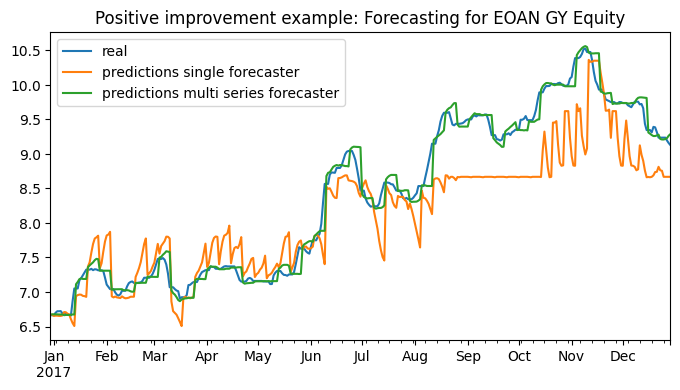

In [18]:
fig, ax=plt.subplots(figsize=(8, 4))
data_test['EOAN GY Equity'].plot(ax=ax)
predictions['EOAN GY Equity'].plot(ax=ax)
predictions_ms['EOAN GY Equity'].plot(ax=ax)
ax.legend(['real', 'predictions single forecaster', 'predictions multi series forecaster'])
ax.set_xlabel('')
ax.set_title('Positive improvement example: Forecasting for EOAN GY Equity')

Text(0.5, 1.0, 'Negative improvement example: Forecasting for IBE SQ Equity')

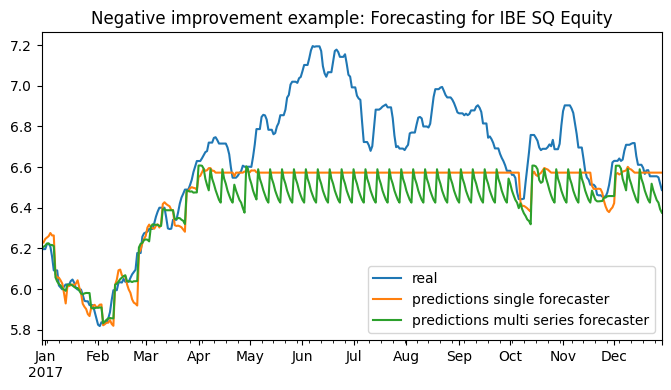

In [19]:
fig, ax=plt.subplots(figsize=(8, 4))
data_test['IBE SQ Equity'].plot(ax=ax)
predictions['IBE SQ Equity'].plot(ax=ax)
predictions_ms['IBE SQ Equity'].plot(ax=ax)
ax.legend(['real', 'predictions single forecaster', 'predictions multi series forecaster'])
ax.set_xlabel('')
ax.set_title('Negative improvement example: Forecasting for IBE SQ Equity')

Text(0.5, 1.0, 'Similar predictions example: Forecasting for VIV FP Equity')

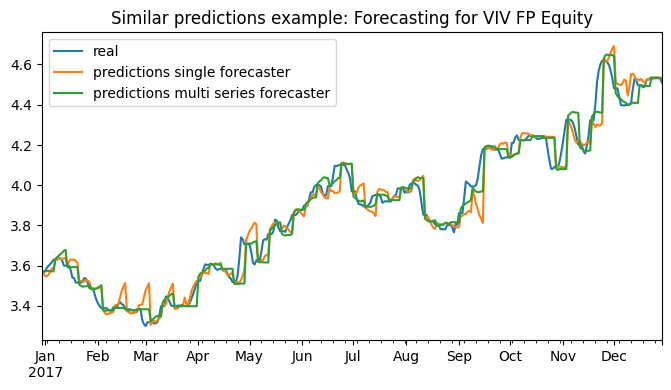

In [20]:
fig, ax=plt.subplots(figsize=(8, 4))
data_test['VIV FP Equity'].plot(ax=ax)
predictions['VIV FP Equity'].plot(ax=ax)
predictions_ms['VIV FP Equity'].plot(ax=ax)
ax.legend(['real', 'predictions single forecaster', 'predictions multi series forecaster'])
ax.set_xlabel('')
ax.set_title('Similar predictions example: Forecasting for VIV FP Equity')

Looks like that using a multi time series forecaster is simply better.

---

In [68]:
def evaluate_forecast(predictions, actual):
    mae = mean_absolute_error(predictions, actual)
    mse = mean_squared_error(predictions, actual)
    mape = mean_absolute_percentage_error(predictions, actual)
    print(f'MAE = {mae}')
    print(f'MSE = {mse}')
    print(f'MAPE = {mape}')

In [88]:
predictions_ms.describe()

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,...,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,123.250182,13.488769,108.261592,59.998710,26.741598,2.677529,81.476458,177.054928,4.276225,24.305020,...,174.492609,7.140853,103.756264,81.331499,14.739872,14.209143,8.397616,15.679302,101.153638,15.870426
std,10.376560,0.986023,5.513621,1.173181,0.346023,0.234410,4.327279,1.306253,0.123874,0.842412,...,2.099519,0.466276,1.072687,0.574613,0.733680,0.715935,1.163701,1.088006,3.377595,0.600535
min,108.240364,11.561148,97.347041,54.573210,25.429954,2.119233,72.516749,175.390876,3.871078,22.433719,...,167.754205,6.046130,101.888251,80.610436,13.195715,13.042154,6.664264,13.337884,92.516218,14.762967
25%,115.785332,12.680355,104.375488,59.903964,26.682083,2.521272,78.396075,175.710808,4.252434,23.677072,...,173.494846,7.009965,102.684001,80.751455,14.097710,13.725382,7.250413,14.880089,98.696147,15.450814
50%,121.736404,13.677339,106.772869,60.250911,26.805041,2.792052,81.783249,176.789879,4.313634,24.253434,...,174.746022,7.267404,103.571397,81.227085,15.034228,13.998206,8.438725,15.794771,101.407818,15.841957
75%,125.383444,14.363158,112.068910,60.592953,26.964892,2.852202,84.567393,178.192710,4.361448,25.164982,...,176.140819,7.472541,104.725043,81.845420,15.296672,14.722639,9.460152,16.621574,103.364458,16.300583
max,153.524828,14.916616,120.188918,61.194547,27.145576,2.984067,91.556778,179.328911,4.408419,25.498465,...,177.750785,7.874694,105.739503,82.356468,15.741877,15.773194,10.560556,17.601561,109.315632,17.403593


In [80]:
evaluate_forecast(predictions_ms, data_test.iloc[1:, :])

MAE = 3.477833534811837
MSE = 95.0305015097913
MAPE = 0.041918851710159646


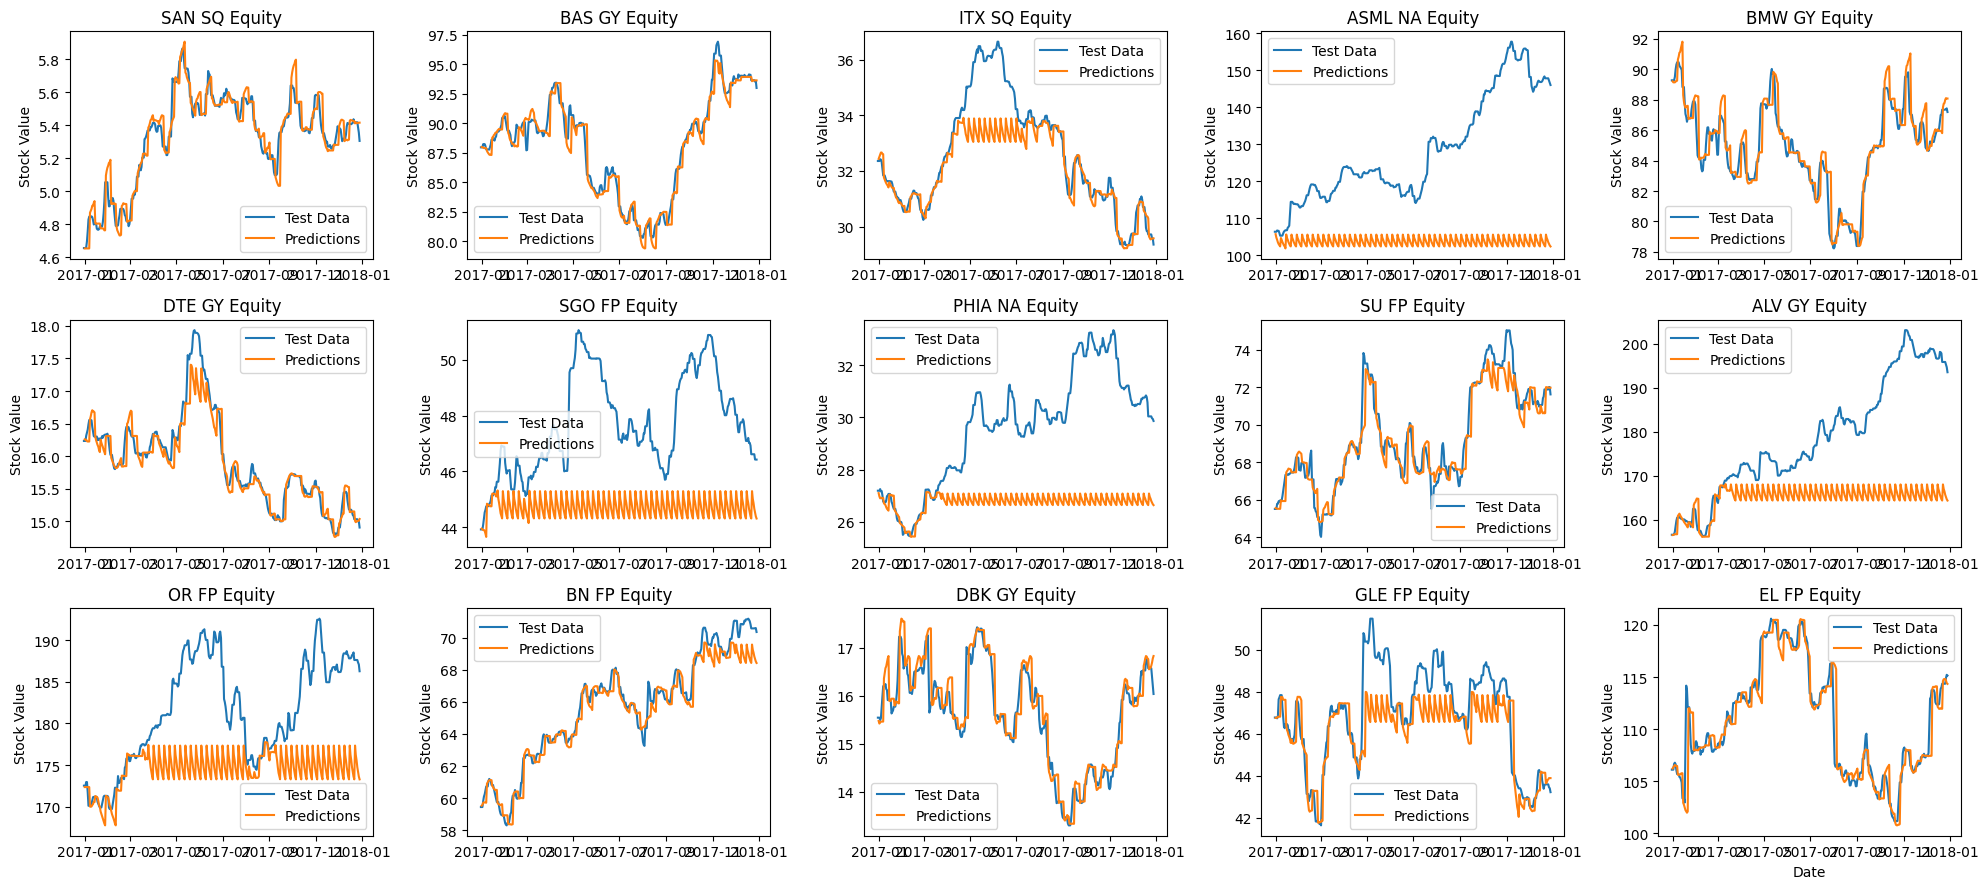

In [119]:
stocks_to_plot = np.random.choice(np.arange(41), size=15, replace=False)

num_rows = 3
num_cols = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 9))

for i, stock in enumerate(stocks_to_plot):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].plot(data_test.index, data_test.iloc[:, stock], label='Test Data')
    axs[row, col].plot(predictions_ms.index, predictions_ms.iloc[:, stock], label='Predictions')

    axs[row, col].set_ylabel('Stock Value')
    axs[row, col].set_title(data_test.iloc[:, stock].name)
    axs[row, col].legend()

# Hide empty subplots
for i in range(len(stocks_to_plot), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [66]:
portfolios = get_ranking(predictions_ms, N = [5, 7, 10], prices=True)
 
tot_performance, portfolio_series = calc_portfolios(portfolios, tukey.loc[predictions_ms.index[0]:], initial_investment=100)

tot_performance['Index performance'] = ((1 + index_returns.loc[predictions_ms.index[0]:]).prod() - 1) * 100
tot_performance

{'Top5 performance': 24.51333098039352,
 'Top7 performance': 21.642995440723155,
 'Top10 performance': 18.78304579004083,
 'Index performance': 8.73696808872011}

In [67]:
plot_portfolios(portfolio_series, index_ret=index_returns)

Remember that these performances are obtained with backtested predictions.

---

Not backtested predictions are basically constant. Let's see.

In [124]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=1),
                    lags               = 14,
                    transformer_series = MinMaxScaler(),
                )

In [125]:
forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: MinMaxScaler() 
Transformer for exog: None 
Window size: 14 
Series levels (names): ['VOW3 GY Equity', 'ENGI FP Equity', 'BAYN GY Equity', 'BNP FP Equity', 'PHIA NA Equity', 'ISP IM Equity', 'SAN FP Equity', 'MC FP Equity', 'ENEL IM Equity', 'CS FP Equity', 'VIV FP Equity', 'SU FP Equity', 'MUV2 GY Equity', 'EL FP Equity', 'BAS GY Equity', 'ORA FP Equity', 'TEF SQ Equity', 'null', 'SIE GY Equity', 'AI FP Equity', 'null.1', 'BN FP Equity', 'SAN SQ Equity', 'DG FP Equity', 'BMW GY Equity', 'null.2', 'ALV GY Equity', 'IBE SQ Equity', 'GLE FP Equity', 'ITX SQ Equity', 'SGO FP Equity', 'OR FP Equity', 'BBVA SQ Equity', 'ASML NA Equity', 'SAP GY Equity', 'INGA NA Equity', 'ENI IM Equity', 'EOAN GY Equity', 'DBK GY Equity', 'ABI BB Equity', 'DTE GY Equity'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of e

In [126]:
preds = forecaster.predict(len(data_test))
preds.describe()

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
count,365.000000,365.000000,365.000000,365.000000,365.000000,3.650000e+02,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,116.638687,12.125156,97.347325,59.924766,26.951597,2.434596e+00,75.771926,172.768821,4.178630,23.395261,...,172.356944,6.420152,100.259747,79.455223,13.272624,15.505010,6.674426,15.461572,100.360711,15.867557
std,0.063569,0.007397,0.002417,0.037333,0.009247,4.446988e-16,0.003362,0.644520,0.001171,0.057358,...,0.000000,0.000071,0.530294,0.285072,0.011706,0.005963,0.000458,0.002368,0.012490,0.079067
min,116.032863,12.116124,97.347041,59.827834,26.904281,2.434596e+00,75.760824,172.243978,4.160396,23.345713,...,172.356944,6.419196,99.849165,79.274878,13.267220,15.415872,6.670562,15.420751,100.180227,15.818432
25%,116.645591,12.116124,97.347041,59.923105,26.951635,2.434596e+00,75.771612,172.669994,4.178728,23.386628,...,172.356944,6.420157,100.183327,79.411134,13.271404,15.505449,6.674447,15.461688,100.361634,15.848703
50%,116.645591,12.125236,97.347041,59.923105,26.951635,2.434596e+00,75.771612,172.669994,4.178728,23.386628,...,172.356944,6.420157,100.183327,79.411134,13.271404,15.505449,6.674447,15.461688,100.361634,15.848703
75%,116.645591,12.132593,97.347041,59.923105,26.951635,2.434596e+00,75.771612,172.669994,4.178728,23.386628,...,172.356944,6.420157,100.183327,79.411134,13.271404,15.505449,6.674447,15.461688,100.361634,15.848703
max,116.794538,12.132593,97.367808,60.500420,27.105457,2.434596e+00,75.810542,179.279373,4.179794,23.930718,...,172.356944,6.420157,105.739503,82.356468,13.428452,15.517932,6.676466,15.474475,100.361634,16.258329


In [127]:
evaluate_forecast(preds, data_test)

MAE = 5.847233604521603
MSE = 137.59801610658639
MAPE = 0.09945160851001196


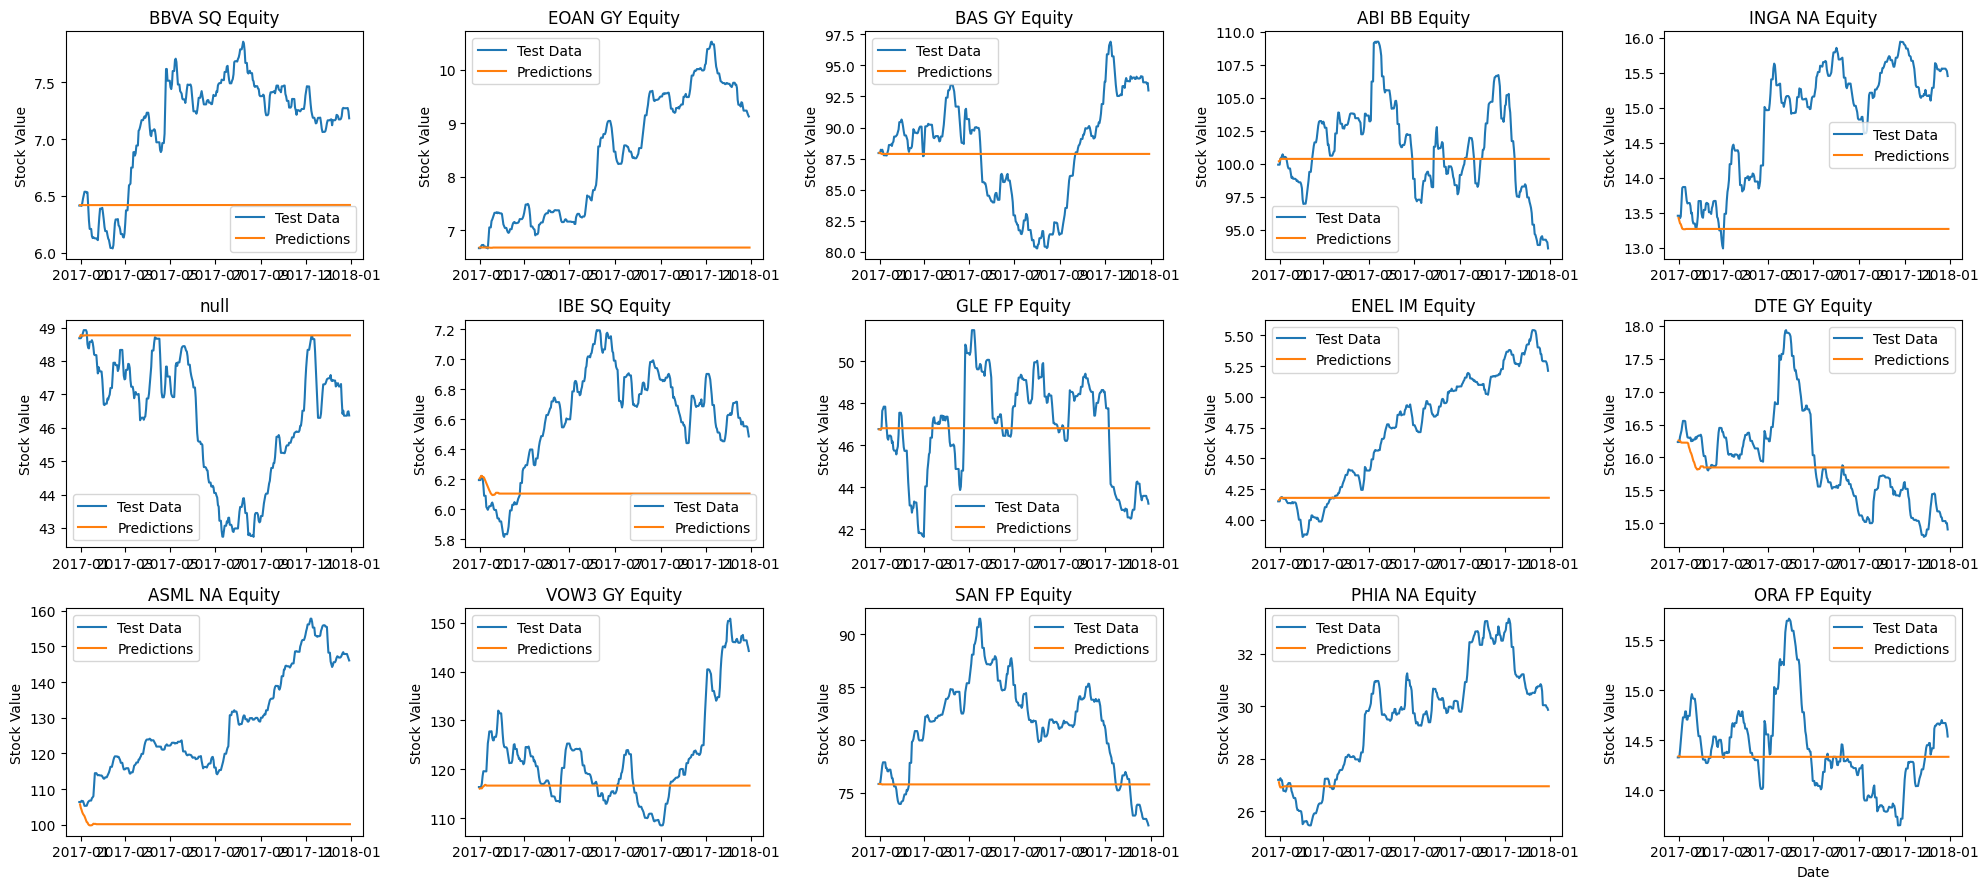

In [128]:
stocks_to_plot = np.random.choice(np.arange(41), size=15, replace=False)

num_rows = 3
num_cols = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 9))

for i, stock in enumerate(stocks_to_plot):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].plot(data_test.index, data_test.iloc[:, stock], label='Test Data')
    axs[row, col].plot(preds.index, preds.iloc[:, stock], label='Predictions')

    axs[row, col].set_ylabel('Stock Value')
    axs[row, col].set_title(data_test.iloc[:, stock].name)
    axs[row, col].legend()

# Hide empty subplots
for i in range(len(stocks_to_plot), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [129]:
portfolios = get_ranking(preds, N = [5, 7, 10], prices=True)
 
tot_performance, portfolio_series = calc_portfolios(portfolios, tukey.loc[preds.index[0]:], initial_investment=100)

tot_performance['Index performance'] = ((1 + index_returns.loc[preds.index[0]:]).prod() - 1) * 100
tot_performance

{'Top5 performance': 13.467075819228441,
 'Top7 performance': 9.78733290073059,
 'Top10 performance': 8.04650071686872,
 'Index performance': 8.73696808872011}

In [130]:
plot_portfolios(portfolio_series, index_ret=index_returns)